In this notebook, I am gonna train a neural network to classify whether the person whose face is in an image is a man or woman. The dataset can be found in the ```data``` folder, or **you can create your own dataset** using the notebook *Data Processing*.

## Some preparations

First, some options and imports. We will use the ```fastai``` library, which was built on top of ```PyTorch```

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

For the neural net to train smoother and faster, all the image is going to be resized to the length assigned by the ```sz``` variable. The ```PATH``` variable is the folder in which the dataset is stored.

In [4]:
PATH = "data/"
sz=224

## Model creation

To save time and computation resource, I am using a pretrained neural net called [```resnet models```](https://github.com/KaimingHe/deep-residual-networks) as a starting point. 

In [5]:
arch=resnet34

Also, to increase the accuracy, I'm gonna apply ```data augmentation``` to the data. Since people's face are not normally seen upside down, we will apply only the zoom-in, horizontal reflection and focus along the side effects.

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

Now, let's create a ```learner``` (i.e. a neural network object using the model structure ```arch``` and the dataset ```data``` we've just defined. The ```precompute``` option is set to **True**, implying that the activation of the *penultimate layer* (i.e. the layer before the last one) is precomputed. Since in the next step, we will need to train only the last layer, this precomputation helps saving time; but we will have to turn it off later for the data augmentation to take effects.

In [7]:
learner = ConvLearner.pretrained(arch, data, precompute=True)

## Training process

As we use a pretrained model with 1000 classes, we need to replace the last layer with a new layer of size ```1``` (Since we only have 2 classes). By default, this replacement is automatically done when we start training the model. Let's train the learner with one epoch to see where we are.

In [8]:
learner.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                
    0      0.667974   0.378336   0.907986  



[0.37833554, 0.9079861044883728]

So, currently, without data augmentation and by only training the last layer for 1 epoch, we have accuracy of 90.8%. Now, let's turn off the precomputation, so that the data can be augmented.

In [9]:
learner.precompute=False

We will now train the network with data generated from data augmentation process. We also apply *stochastic gradient descent with restarts (SGDR)*, which means the learning rate is gradually decreased, but eventually be increased, so that the learner will be able to "*jump out*" of a minimum point in case that minimum point is to sensitive to changes (i.e. a small changes of weights cause big changes in the loss). That way, the learner will be able to find a more stable minimum.

We will continue the process with ```learning rate``` of ```0.01```, which is gradually decrease over a cycle, before being pushed back to the start value (0.01).
The ```cycle_len``` parameter defines that the cycle in which ```learning rate``` is decreased is 1 epoch. Number ```3``` is the number of cycles, so since each cycle lasts 1 epoch, we will have 3 epochs.

In [10]:
learner.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.401625   0.314631   0.9375    
    1      0.367782   0.251286   0.945312                
    2      0.357175   0.219051   0.953125                



[0.21905114, 0.953125]

Now, we want to train not only the last layer, but also the whole neural net. By default, all the layers, except the last one, are ```frozen```, i.e. *unlearnable*, so we need to ```unfreeze``` them first.

In [11]:
learner.unfreeze()

In a pretrained model, the earlier layers are more general and the later layers are more customed. We, therefore, want to apply smaller learning rate for earlier layers and bigger learning rate for later layers. We can do that by setting a numpy 1-D array of the learning rates.

In [12]:
lr=np.array([1e-4,1e-3,1e-2])

The *SGDR* is great in helping us avoiding sensitive minimum, but suppose we find a not sensitive minimum, if we keep restarting our learning rate in every epoch, we might have a harder time finding the "sweet spot". Hence, overtime, it makes sense to lengthening the cycles, so that the weights have more chances to be fine-tuned. We add the ```cycle_mult``` parameter equals to 2, which means the cycle length with be doubled in every cycle. That way, if we start with cycle length = 1 and have 3 cycles, we should end up with ```1 + 1*2 + 1*2*2 = 7``` epochs.

In [13]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.452861   0.268934   0.897569  
    1      0.423952   0.248021   0.925347                
    2      0.365723   0.257023   0.917535                
    3      0.329648   0.234849   0.917535                
    4      0.28861    0.224863   0.923611                
    5      0.255626   0.222039   0.931424                
    6      0.23439    0.223236   0.931424                



[0.22323565, 0.9314236044883728]

Looking at the losses, it seems that the result is still improving, so we might wanna get another round. But it might turn out to be worse after the round, so maybe it's best to save our model first.

In [14]:
learner.save('learner_all')

In [21]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      0.180886   0.220206   0.931424  
    1      0.170063   0.213852   0.9375                  
    2      0.157439   0.214009   0.953125                
    3      0.148967   0.212882   0.931424                
    4      0.143777   0.217321   0.945312                
    5      0.134098   0.215585   0.953125                
    6      0.127414   0.215003   0.953125                



[0.21500295, 0.953125]

Maybe another round?

In [22]:
learner.save('learner_all')

In [23]:
learner.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      0.067503   0.212778   0.953125  
    1      0.075482   0.220517   0.953125                 
    2      0.072375   0.221545   0.960938                 
    3      0.069137   0.234122   0.9375                   
    4      0.076347   0.236134   0.945312                 
    5      0.072049   0.233048   0.945312                 
    6      0.072358   0.233604   0.953125                 



[0.23360425, 0.953125]

It seems that the model is becoming overfit. That's actually not a surprise, considering our size of dataset. Now, let's reset the learner to its last-known good state.

In [24]:
learner.load('learner_all')

## Fine-tuning results

Lastly, at test time, since our images are not always squared, there are chances that the prediction is made in an area, in which the main object is not there, which makes it wrong. We can partly avoid that issue by making sure that the prediction is taken in different areas of the same picture, and take average of these predictions as the final prediction. In practice, we use the main image and 4 random augmented versions of it to make prediction. This is called ```test-time augmentation``` or ```TTA```.

In [25]:
log_preds,y = learner.TTA()
probs = np.mean(np.exp(log_preds),0)

Our final result is 92% accuracy. Not bad for a dataset with just almost 500 images and a training process of 11 epochs.

In [26]:
accuracy_np(probs, y)

0.92

## Result Analysis

We will analyze the results using confusion matrix

In [27]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[45  5]
 [ 3 47]]


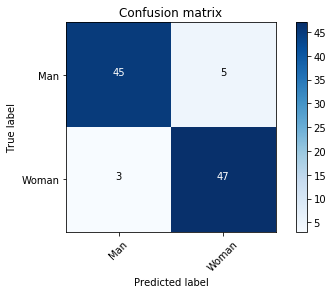

In [29]:
plot_confusion_matrix(cm, data.classes)

Now let's look at some of the most correctly, incorrectly and uncertainedly classified images

In [30]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [31]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [32]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


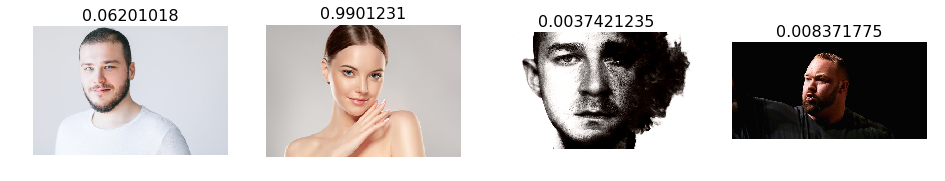

In [33]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


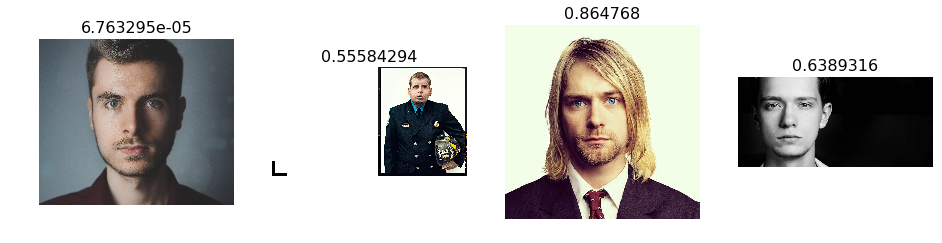

In [34]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Well, to be fair, the "girl" in the first image was likely to be a guy, who somehow became a "woman" because of Google. Can't blame the model for that.

Most uncertain predictions


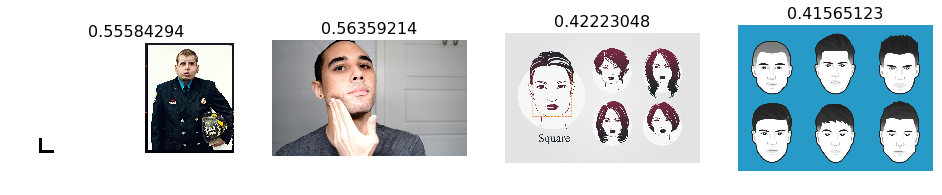

In [35]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")